In [4]:
from dpks.quant_matrix import QuantMatrix

ModuleNotFoundError: No module named 'xgboost'

In [2]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file="../tests/input_files/design_sepsis.tsv")

In [3]:
quantified_data = (
    qm.normalize(
        method="mean",
    )
    .quantify(method="top_n")
)

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

def _generate_data_matrices(
     quantitative_data: QuantMatrix, scale: bool
) -> tuple:
    le = LabelEncoder()
    Y = le.fit_transform(quantitative_data.quantitative_data.var["group"].values)
    X = quantitative_data.quantitative_data.X.copy().transpose()
    X = np.nan_to_num(X, copy=True, nan=0.0)
    if scale:
        X = StandardScaler().fit_transform(X)
    return X, Y

scale = True
X, y = _generate_data_matrices(quantified_data, scale)

In [5]:
param_grid = {
        'min_child_weight': [0.01, 0.1, 0.5, 1, 5, 10, 25],
        'gamma': [0.1, 0.5, 1, 1.5, 2, 5, 7, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5, 6, 7,8,9,10,12,15,20],
        'max_leaves': [1, 2,3,4,5,6,7,8,9,10,15,20,25,30],
        "learning_rate": [0.0001,0.001, 0.01, 0.1, 1],
        "reg_alpha": [1e-10, 1e-7, 1e-6, 1e-5, 1e-2, 0.1, 1, 10, 15, 20,40, 60, 100],
        "reg_lambda": [1e-5, 1e-2, 0.1, 1, 5, 15, 20, 25, 100],
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 1000],
    'scale_pos_weight': [1, 3, 5, 7, 10, 15]
        }


In [6]:
from sklearn.model_selection import cross_val_score
import xgboost

clf = xgboost.XGBClassifier(

                )

In [8]:
quantified_data.classify(clf, calculate_feature_importance=False, 
                         run_param_search =True, 
                         verbose=True, 
                         param_grid=param_grid, 
                         param_search_method='genetic',
                         threads=8,
                         n_generations=3,
                         pop_size=10, 
                         n_survive=5)

Generation 0
Accuracy 0.7914529914529914
Best param {'min_child_weight': 5, 'gamma': 1, 'subsample': 0.6, 'colsample_bytree': 0.1, 'max_depth': 7, 'max_leaves': 30, 'learning_rate': 0.1, 'reg_alpha': 1e-05, 'reg_lambda': 0.1, 'n_estimators': 100, 'scale_pos_weight': 5}
Generation 1
Accuracy 0.7964257964257963
Best param {'min_child_weight': 0.01, 'gamma': 0.5, 'subsample': 1.0, 'colsample_bytree': 0.1, 'max_depth': 2, 'max_leaves': 5, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 25, 'n_estimators': 300, 'scale_pos_weight': 1}
Generation 2
Accuracy 0.7964257964257963
Best param {'min_child_weight': 0.01, 'gamma': 0.5, 'subsample': 1.0, 'colsample_bytree': 0.1, 'max_depth': 2, 'max_leaves': 5, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 25, 'n_estimators': 300, 'scale_pos_weight': 1}
Accuracy:  0.7914529914529914


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<AxesSubplot:xlabel='generation', ylabel='scores'>

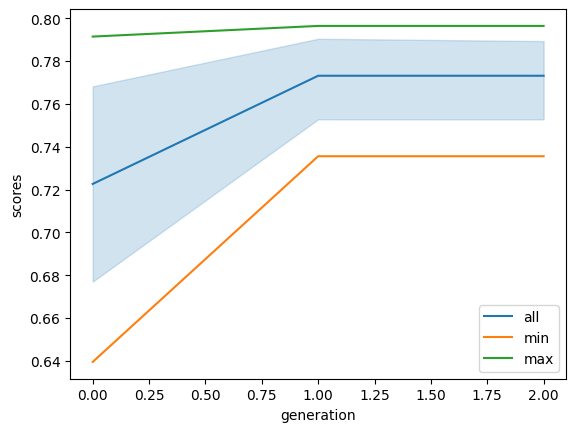

In [10]:
import pandas as pd
import seaborn as sns
populations = quantified_data.parameter_populations
plot_dict = {'generation': [], 'scores' : []}
for generation in populations.keys():
    population = populations[generation]
    for individual in population:
        score, d = individual
        plot_dict['generation'].append(generation)
        plot_dict['scores'].append(score)

plot_frame = pd.DataFrame(plot_dict)
max_frame = plot_frame.groupby('generation', as_index=False).max()
min_frame = plot_frame.groupby('generation', as_index=False).min()
sns.lineplot(data=plot_frame, x='generation', y='scores', label='all')
sns.lineplot(data=min_frame, x='generation', y='scores', label='min')
sns.lineplot(data=max_frame, x='generation', y='scores', label='max')
